In [135]:
import pandas as pd
import numpy as np


# to make this notebook's output identical at every run
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from zlib import crc32

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV

from scipy import stats

In [2]:
# Load the data
housing = pd.read_csv('../Chapter 2/housing.csv')

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We can see that total_bedrooms has about 200 missing values.

In [5]:
# View categories of categorical variables (ocean_proximity)
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
# View summary stats of numerical variables
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


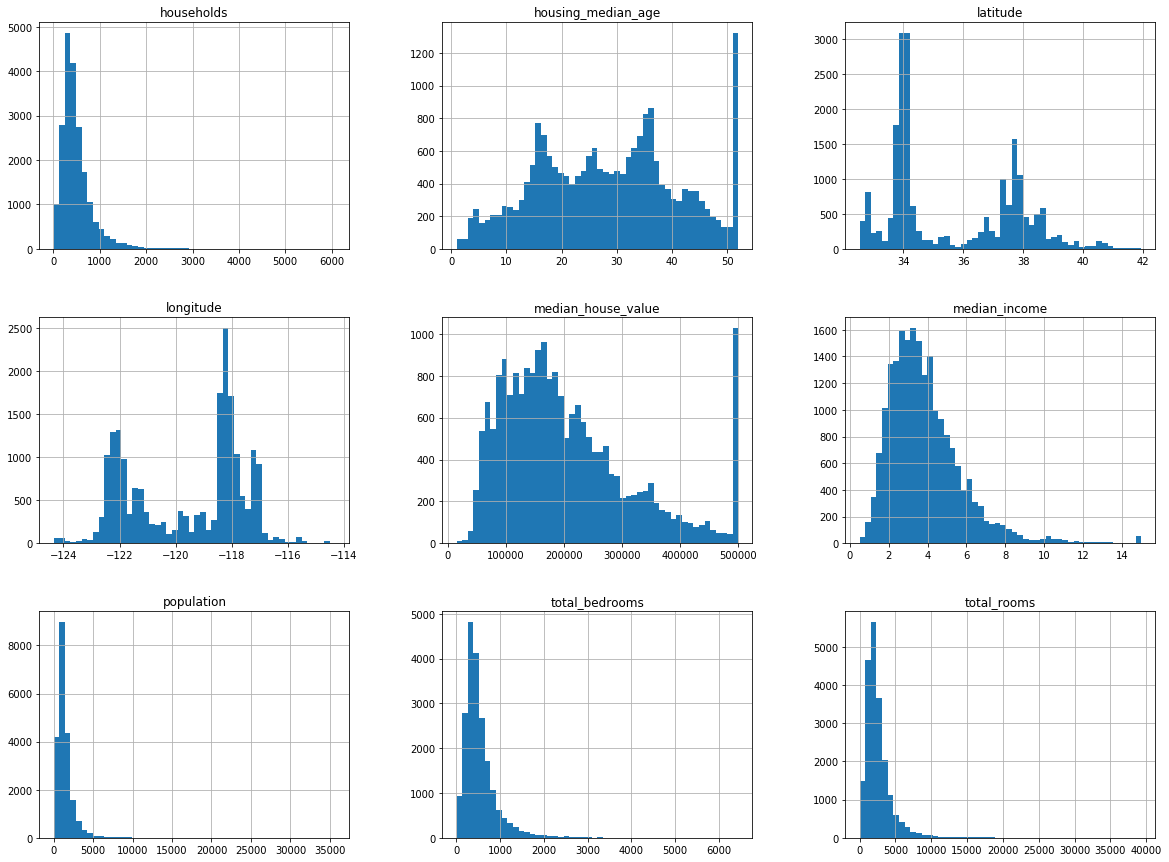

In [7]:
# Plot histograms of each numerical variable
housing.hist(bins=50, figsize=(20,15))
plt.show()

### Issues to note:

1. median_income has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes.


2. housing_median_age and  median_house_value were also capped. The latter may be a serious problem since it is our target attribute. Remove those districts from the training set (and also from the test set, since our system should not be evaluated poorly if it predicts values beyond 500,000).


3. These attributes have very different scales.


4. Many histograms are tail-heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

# Create a Test Set

In [8]:
# for illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), 'train +', len(test_set), 'test')

16512 train + 4128 test


Problem with the above function is that each time it's run, it will generate a different test set. Over time, the ML algos will get to see the whole dataset...

One solution is to save test set on first run and then load it in subsequent runs. Another is to set random number generator's seed (ie np.random.seed(42)) so it always generates the same shuffled indices.But both these solutions will break next time you fetch an updated data set.

A common solution is to use each instance's identifier to decide whether or not it should go in the test set.

In [9]:
# Function to check test set's identifier.
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

# Function to split train/test
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

# Unfortunately, housing dataset doesn't have an identifier column.
# Simplest solution is to use the row index as the ID.
housing_with_id = housing.reset_index() # adds an 'index' column
tran_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

If you use the row index as a unique identifier, you need to make sure that new data gets appended to the end of the dataset, and no row ever gets deleted. If this is not possible, then you can try to use the most stable features to build a unique identifier. For example, a district’s latitude and longitude are guaranteed to be stable for a few million years, so you could combine them into an ID like so:

In [10]:
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

Scikit-Learn provides function split_train_test similar to the one defined earlier, with additional features of random_state, and you can pass it multiple datasets with an identical number of rows, and it will split them on the same indices.

In [11]:
# Split using sklearn's train_test_split()
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [12]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


# Feature: median_income
Suppose you chatted with experts who told you that the median income is a very important attribute to predict median housing prices. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, you first need to create an income category attribute. Let’s look at the median income histogram more closely.

This concept is called stratified sampling: the population is
divided into homogeneous subgroups called strata, and the right number of instances is sampled from each stratum to guarantee that the
test set is representative of the overall population. 

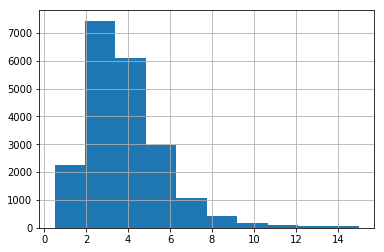

In [13]:
housing['median_income'].hist()

The following code creates an income category attribute by binning median_income into 5 categories using pd.cut(): 1=(0:1.5), 2=(1.5:3), 3=(3:4.5), 4=(4.5:6), 5=(6:infinity)

In [20]:
housing['income_cat'] = pd.cut(housing['median_income'],
                              bins=[0., 1.5, 3., 4.5, 6., np.inf],
                              labels=[1, 2, 3, 4, 5])

In [31]:
print(housing['income_cat'].dtype)
housing['income_cat'] = housing['income_cat'].astype(int)
print(housing['income_cat'].dtype)

float64
int64


In [32]:
housing.income_cat.value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

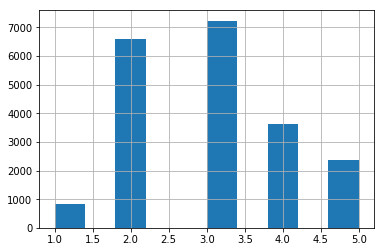

In [33]:
# income_cat histogram
housing.income_cat.hist()

In [34]:
# Perform stratified sampling based on the income category
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']): # split.split(data, labels)
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [35]:
# Let's test our split by checking the income category proportions in the full housing dataset
housing['income_cat'].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [36]:
# Test income category proportions of stratified training set
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

In [37]:
# Test income category proportions of stratified test set
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [39]:
# Function for comparing proportions of stratified data sets

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
    }).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

Notice how similar the proportions are to the original dataset--almost identical.

In [40]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


Now you should remove the income_cat attribute so the data is back to its original state:

In [41]:
for set in (strat_train_set, strat_test_set):
    set.drop(['income_cat'], axis=1, inplace=True)

# Exploring the Data

In [42]:
# Create a copy of training set to play with it without harming the training set
housing = strat_train_set.copy()

### Visualize the Data

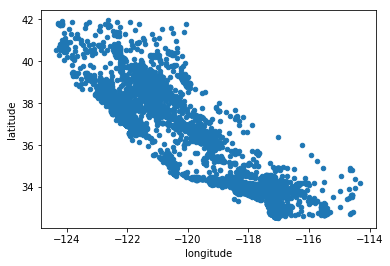

In [44]:
housing.plot(kind='scatter', x='longitude', y='latitude')

Set the alpha option to 0.1 to easily visualize places with high density of data points.

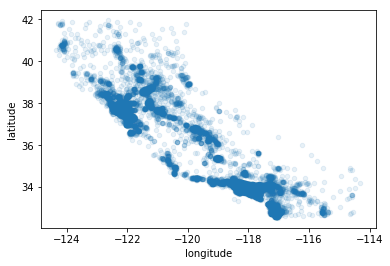

In [45]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

The high-density areas seem to be the bay area, Los Angeles, and San Diego--plus a long line in the Central Valley, particularly around Fresno and Sacramento.

Now Let's look at the housing prices.

The radius of each circle represents the district's population (option s).

The color represents the price (option c).

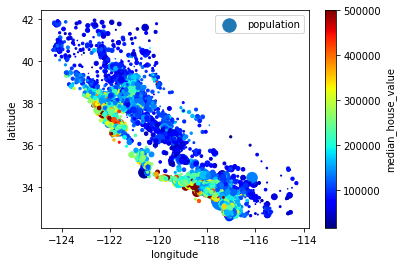

In [46]:
housing.plot(kind='scatter',
            x='longitude',
            y='latitude',
            s=housing['population']/100, label='population',
            c='median_house_value', cmap=plt.get_cmap('jet'),
            colorbar=True,
            sharex=False,
)
plt.legend()

We can see that housing prices are very much correlated with location (ie close to ocean) and to population density.

# Looking for Correlations

We can easily compute the standard correlation coefficient (Pearson's r) between every pair of attributes using the corr() method:

In [47]:
# Correlation Matrix
corr_matrix = housing.corr()

Now let's look at how much each attribute correlates with the median house value:

In [48]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

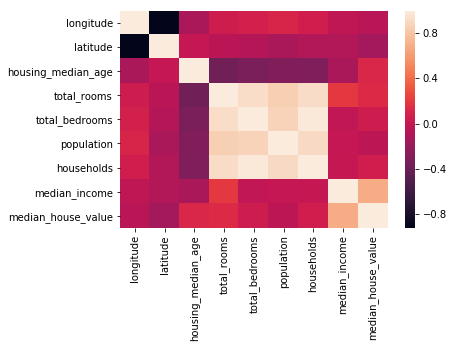

In [49]:
# Heatmap
sns.heatmap(corr_matrix)

Another way to check for correlation between attributes is to use Seaborn's pairplot function, which plots every numerical attribute against every other numerical attribute. Since there are now 11 numerical attributes, you would get 11^2 = 121 plots. So let's just focus on a few promising attributes that seem most correlated with median_housing_value.

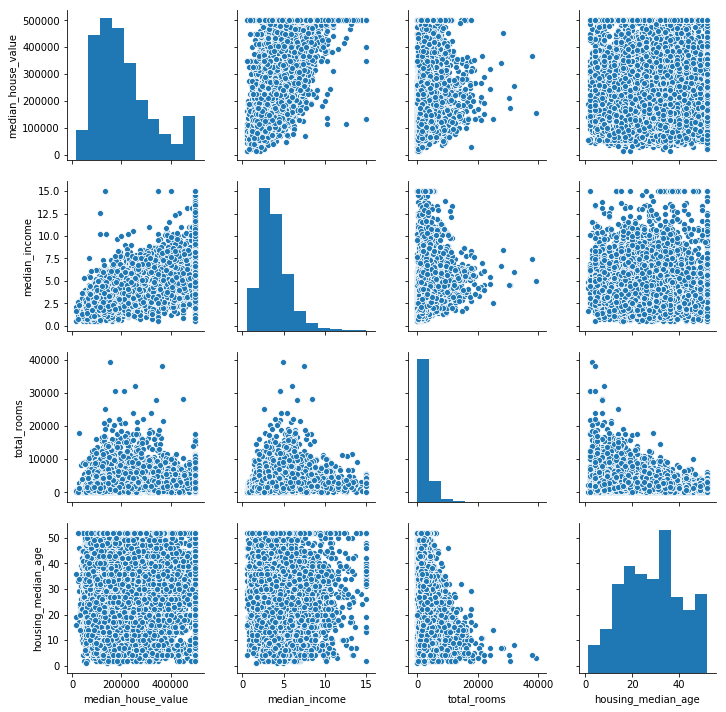

In [50]:
# Pair Plot (scatter matrix)
attributes = ['median_house_value',
              'median_income',
              'total_rooms',
              'housing_median_age'
             ]
sns.pairplot(housing[attributes])

The most promising attribute to predict the median house value is the median income (recognizable positive correlation), so let's zoom in on their correlation scatterplot.

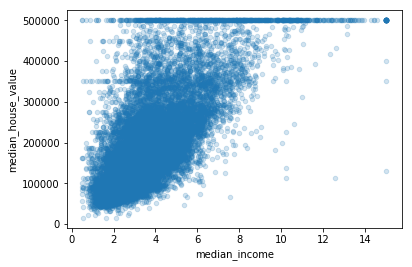

In [51]:
# Scatterplot: median_income vs median_house_value
housing.plot(kind='scatter',
             x='median_income',
             y='median_house_value',
             alpha=.2)

1. The correlation is strong.


2. The price cap is clearly visible at 500,000.

But this plot reveals other less obvious straight lines:

A horizontal line around 450,000, another around 350,000, perhaps one around 280,000, and a few more below that. We may want to try removing the corresponding districts to prevent our algorithms from learning to reproduce these data quirks.

# Attribute Combinations

It would make sense to combine some attributes so they make sense in context:

1. Total number of rooms in a district isn't useful if you don't know how many households there are. Create rooms/household.


2. Total number of bedrooms isn't as useful alone. Compare it to number of rooms.


3. Population can become population per household.

In [52]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

Let's look at the correlation matrix again:

In [53]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

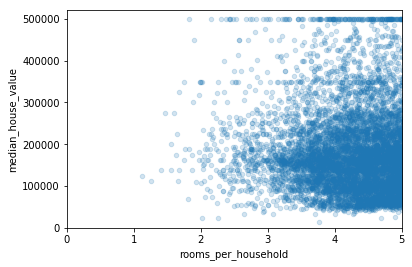

In [55]:
# Scatter of rooms_per_household vs. median_house_value
housing.plot(kind='scatter',
            x='rooms_per_household',
            y='median_house_value',
            alpha=0.2)
plt.axis([0,5,0,520000])
plt.show()

We increased some correlations by combining features.

In [56]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Prepare the Data for Machine Learning Algorithms

## Data Cleaning

Drop the output column in your training set, and save that column as your housing_labels.

In [57]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

### Missing Values

Create a sample of incomplete rows to play with for example.

In [58]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


total_bedrooms has some missing values. We have 3 options:

1. Get rid of the corresponding districts.


2. Get rid of the whole attribute.


3. Set the values to some value (zero, the mean, the median, etc).

If you use option 3, be sure to save the median value so you can apply it to your test set as well.

In [59]:
# Option 1:
sample_incomplete_rows.dropna(subset=['total_bedrooms'])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [60]:
# Option 2:
sample_incomplete_rows.drop('total_bedrooms', axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [61]:
# Option 3:
median = housing['total_bedrooms'].median()
sample_incomplete_rows['total_bedrooms'].fillna(median, inplace=True)
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


Scikit-Learn provides the SimpleImputer class for missing values.

In [62]:
# Imputer is a transformer estimator
imputer = SimpleImputer(strategy='median')

Since the median can only be computed on numerical attributes, create a copy of the data w/o text attribute ocean_proximity.

In [63]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [64]:
# fit the training data
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [65]:
# View imputer values
np.set_printoptions(suppress=True) # suppress scientific notation
print(imputer.statistics_)
print(housing_num.median().values) # code equivalent to .statistics_

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


Transform the training set:

In [66]:
# Could have done fit_transform in the beginning instead
# to transform the training set
X = imputer.transform(housing_num)
print(X) # returns Numpy array of transformed features

[[-121.89     37.29     38.     ...  710.      339.        2.7042]
 [-121.93     37.05     14.     ...  306.      113.        6.4214]
 [-117.2      32.77     31.     ...  936.      462.        2.8621]
 ...
 [-116.4      34.09      9.     ... 2098.      765.        3.2723]
 [-118.01     33.82     31.     ... 1356.      356.        4.0625]
 [-122.45     37.77     52.     ... 1269.      639.        3.575 ]]


In [71]:
# put Numpy array back into Pandas Dataframe
housing_tr = pd.DataFrame(X,
                          columns=housing_num.columns,
                          index = list(housing.index.values))
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [72]:
# Check for missing values
housing_tr.isnull().values.any()

False

In [73]:
# Check that your housing_tr filled in the incomplete rows correctly
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [70]:
imputer.strategy

'median'

### Converting categorical attributes to numerical

In [75]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


Use sklearn's OrdinalEncoder to encode string categorical attributes as integers (but OneHotEncoder() includes this step if you need to create binary rows for your categorical variables).

In [77]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [78]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Use sklearn's OneHotEncoder to convert categories to binary columns.

In [80]:
# OneHotEncoder
cat_encoder = OneHotEncoder(sparse=False) # set sparse = False for converting to dense array instead of SciPy sparse array
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [81]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Instead of LabelEncoder and OneHotEncoder, we can use LabelBinarizer to combine both steps in one and return one-hot vectors. However, OneHotEncoder returns a SciPy sparse matrix instead of an array, which takes up much less memory. In order to create a sparse matrix with LabelBinarizer, pass sparse_output=True to LabelBinarizer constructor.

### Custom Transformers

We may need to write our own transformers for tasks like custom cleanup or combining attributes. Create a class and implement 3 methods: fit() (returning self), transform(), and fit_transform().

You can get the fit_transform() by adding TransformerMixin as a base classs.

You can add BaseEstimator as a base class (and avoid *args and \**kargs in your constructor). You will get two extra methods (get_params() and set_params() that will be useful for automatic hyperparameter tuning.

For example, here's a small transformer class that adds the combined attributes we created earlier:

In [82]:
# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ('total_rooms', 'total_bedrooms', 'population', 'households')]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X,
                         rooms_per_household,
                         population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [83]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+['rooms_per_household', 'population_per_household'])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


### Feature Scaling

There are 2 common ways to get all attributes to have the same scale:

1. Min-max scaling (normalization)
    -  Values shifted and rescaled to range from 0 to 1.
    -  Scikit-Learn transformer MinMaxScaler.


2. Standardization
    -  Subtracts mean value (mean=0) and divides by variance so resulting dist has unit variance.
    -  Much less affected by outliers, but can present problems for some algorithms expecting 0-1 values.
    -  Scikit-Learn transformer StandardScaler

### Transformation Pipelines

In [84]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [85]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

This pipeline fits and transforms the transformers and fits the final parameter. But we need to weave in the categorical values into this pipeline. Scikit-Learn provides ColumnTransformer for this:

In [86]:
num_attribs = list(housing_num) # returns list of attributes
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [87]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [88]:
housing_prepared.shape

(16512, 16)

# Select and Train a Model

## Training and Evaluating on the Training Set

## Linear Regression

In [89]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Let's try the full preprocessing pipeline on a few training instances:

In [97]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print('Predictions:', lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [98]:
print('Labels:', list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [100]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [94]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [95]:
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001898

This means a typical prediction error is 68,628 (from RMSE).

Most districts' median_housing_values range between 120,000 and 265,000, so this is not a great score.

This is an example of a model underfitting the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough.

The main ways to fix underfitting are to:

1. Select a more powerful model.

2. Feed the training algorithm with better features

3. Reduce the constraints on the model. (This model is not regularized, so this rules out this option)

## Decision Tree Regressor

Let's train a DecisionTreeRegressor. It's a powerful model, capable of finding complex nonlinear relationships in the data.

In [101]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [102]:
housing_predictions = tree_reg.predict(housing_prepared)

tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

0 error likely means the model has badly overfit the data.

## Cross-Validation

Sklearn's *K-fold cross-validation* randonly splits the training set into 10 distinct subsets called *folds*, then trains and evaluates the Decision Tree model 10 times. The result is an array containing the 10 evaluation scores:

In [104]:
scores = cross_val_score(tree_reg,
                         housing_prepared,
                         housing_labels,
                         scoring='neg_mean_squared_error',
                         cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [105]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

display_scores(tree_rmse_scores)

Scores: [70194.33680785 66827.44875653 70943.83549475 70236.44866746
 72219.36760134 75133.84314832 69784.4396021  71606.6771986
 78265.0939755  70510.49230819]
Mean: 71572.19835606452
Standard deviation: 2980.162774754496


Let's compare Decision Tree's CV to Linear Regression's CV:

In [106]:
lin_scores = cross_val_score(lin_reg,
                            housing_prepared,
                            housing_labels,
                            scoring='neg_mean_squared_error',
                            cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [107]:
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.6740017983507


Linear Regression performs even better than Decision Tree, confirming that Decision tree was very overfit.

## Random Forest Regressor

In [109]:
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [110]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21933.31414779769

In [111]:
forest_scores = cross_val_score(forest_reg,
                               housing_prepared,
                               housing_labels,
                               scoring='neg_mean_squared_error',
                               cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean: 52583.72407377466
Standard deviation: 2298.353351147122


Random Forests look better with a mean RMSE of 52,583. But note the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set.

Possible solutions for overfitting are:

1. Simplify the model


2. Constrain the model (ie regularize it)


3. Get a lot more training data

But we should test many more categories of algorithms first, such as several Support Vector Machines with different kernels, possibly a neural network, etc. without spending too much time tweaking the parameters.

In [117]:
svm_reg = SVR(kernel='linear')
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

Save our model w/ hyperparameters, the trained parameters, and the cross-validation scores, and perhaps the actual predictions. Then we can compare scores across model types, and compare the types of errors they make.

Save sklearn models using sklearn's joblib.

In [112]:
# joblib.dump(my_model, 'my_model.pkl')
# and later...
# my_model_loaded = joblib.load('my_model.pkl')

# Fine-Tune Your Model

### Grid Search

Instead of fiddling with the hyperparameters manually, use sklearn's GridSearchCV. Tell it which hyperparameters you want it to experimment with and what values to try out, and it will evaluate all possible combinations of hyperparameter values using CV.

In [123]:
param_grid = [
    # try 12 (3x4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
     # then try 6 (2x3) combinations with bootstrap set as False
     {'bootstrap': [False],
     'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
    ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+16)*5=90
# rounds of training.
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [124]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [125]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [126]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63669.05791727153 {'max_features': 2, 'n_estimators': 3}
55627.16171305252 {'max_features': 2, 'n_estimators': 10}
53384.57867637289 {'max_features': 2, 'n_estimators': 30}
60965.99185930139 {'max_features': 4, 'n_estimators': 3}
52740.98248528835 {'max_features': 4, 'n_estimators': 10}
50377.344409590376 {'max_features': 4, 'n_estimators': 30}
58663.84733372485 {'max_features': 6, 'n_estimators': 3}
52006.15355973719 {'max_features': 6, 'n_estimators': 10}
50146.465964159885 {'max_features': 6, 'n_estimators': 30}
57869.25504027614 {'max_features': 8, 'n_estimators': 3}
51711.09443660957 {'max_features': 8, 'n_estimators': 10}
49682.25345942335 {'max_features': 8, 'n_estimators': 30}
62895.088889905004 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.14484390074 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.399594730654 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52725.01091081235 {'bootstrap': False, 'max_features': 3, 'n_estimators'

Our RMSE for max_features: 8, n_estimators: 30 is 49,959, which is slightly better than the score we got earlier using the default hyperparameter values (52,634).

RandomizedSearchCV can be used in place of GridSearchCV when the hyperparameter search space is large.

In [127]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.131273,0.014146,0.006748,0.000276,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053749e+09,1.519609e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.442189,0.037347,0.020779,0.004101,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094381e+09,1.327046e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,1.404082,0.286828,0.059299,0.009021,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626879e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.226847,0.044100,0.007503,0.001664,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716852e+09,1.631421e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.724580,0.060861,0.024380,0.010374,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781611e+09,1.268562e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,2.004149,0.061695,0.052166,0.003324,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,...,-2.537877e+09,1.214603e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.270262,0.003766,0.006218,0.000117,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,...,-3.441447e+09,1.893141e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.906282,0.029950,0.024598,0.011864,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,...,-2.704640e+09,1.471542e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,3.074478,0.408434,0.050326,0.004265,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,...,-2.514668e+09,1.285063e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.364212,0.011701,0.006634,0.000608,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,...,-3.348851e+09,1.241864e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


### Ensemble Methods

Another way to fine-tune system is to combine the models that perform best (ensemble).

### Analyze the Best Models and Their Errors

The RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions:

In [128]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.07334424, 0.06290907, 0.0411438 , 0.01467269, 0.01410648,
       0.01487428, 0.0142576 , 0.36615898, 0.05641918, 0.10879296,
       0.05335108, 0.01031149, 0.16478099, 0.00006028, 0.00196042,
       0.00285647])

We can display these importance scores next to their corresponding attribute names:

In [130]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude'),
 (0.05641917918195401, 'rooms_per_hhold'),
 (0.05335107734767581, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.002856474637320158, 'NEAR OCEAN'),
 (0.00196041559947807, 'NEAR BAY'),
 (6.028038672736599e-05, 'ISLAND')]

With this information, we may want to drop some of the less useful features (ie only one ocean_proximity category seems useful, so we could drop the others)

# Evaluate the System on the Test Set

In [133]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test) # only transform, not fit_transform!

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [134]:
final_rmse

47730.22690385927

Our final RMSE is 47,730.

The performance will usually be slightly worse than what we measured using CV w/ hyperparameter tuning because the system ends up fine-tuned to perform well on the validation data. When this happens, resist the temptation to tweak the hyperparameters to make the numbers look good on the test set; the improvements will be unlikely to generalize to new data.

We can compute a 95% confidence interval for the test RMSE:

In [137]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                        loc=np.mean(squared_errors),
                        scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])